In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### Bivariate Normal Data Generation

In [3]:
MU = {
    1: [1,1],
    2: [4,3],
    3: [2,6],
    4: [7,4]
}

COV = {
    1: np.eye(2)*0.05,
    2: np.eye(2)*0.05,
    3: np.eye(2)*0.05,
    4: np.eye(2)*0.05
}

N_SAMPLERS = 4
SAMPLERS = {}
for idx in range(1, N_SAMPLERS+1, 1):
    SAMPLERS[idx] = N(MU[idx], COV[idx])

In [4]:
n = 1000
X_TRAIN, Y_TRAIN = {}, {}
X_TEST, Y_TEST = {}, {}

for cls in SAMPLERS:
    X_TRAIN[cls] = SAMPLERS[cls].sample(n)
    Y_TRAIN[cls] = np.array([cls]*n)
    X_TEST[cls] = SAMPLERS[cls].sample(n)
    Y_TEST[cls] = np.array([cls]*n)

# Dataset
def cls_to_dset(idxs, X, Y):
    x, y = [], []
    for idx in idxs:
        x.extend(X[idx])
        y.extend(Y[idx])
    x = np.array(x)
    y = np.array(y)
    return list(zip(x, y)), x, y

IND_CLS = [1, 2, 3]
OOD_CLS = [4]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)


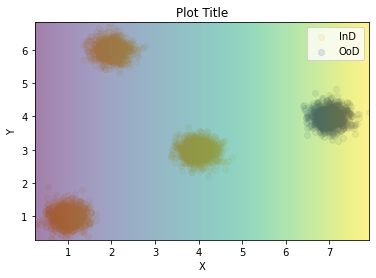

In [5]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.10)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.10)
xi = np.linspace(0, 8, 100, endpoint=True)
yi = np.linspace(0, 8, 100, endpoint=True)
# xy_pos = list(product(x_pos, y_pos))
x, y = np.concatenate((IND_X[:,0],OOD_X[:,0])), np.concatenate((IND_X[:,1],OOD_X[:,1]))
nbins=300
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
plt.pcolormesh(xi, yi, xi, shading='auto', alpha=0.50)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

### Naive Classifier Training

In [17]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configguration
max_epoch = 64
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch)

  5%|▍         | 3/64 [00:00<00:05, 11.14it/s]

Epoch  # 1 | Tri loss: 0.9567                     | Tri accuracy: 0.5866
Epoch  # 1 | Val loss: 0.8274                     | Val accuracy: 0.6684


 20%|██        | 13/64 [00:00<00:03, 16.88it/s]

Epoch  # 11 | Tri loss: 0.0096                     | Tri accuracy: 1.0
Epoch  # 11 | Val loss: 0.0076                     | Val accuracy: 1.0


 39%|███▉      | 25/64 [00:01<00:01, 21.57it/s]

Epoch  # 21 | Tri loss: 0.0009                     | Tri accuracy: 1.0
Epoch  # 21 | Val loss: 0.0008                     | Val accuracy: 1.0


 53%|█████▎    | 34/64 [00:01<00:01, 22.78it/s]

Epoch  # 31 | Tri loss: 0.0003                     | Tri accuracy: 1.0
Epoch  # 31 | Val loss: 0.0003                     | Val accuracy: 1.0


 67%|██████▋   | 43/64 [00:02<00:00, 21.76it/s]

Epoch  # 41 | Tri loss: 0.0002                     | Tri accuracy: 1.0
Epoch  # 41 | Val loss: 0.0002                     | Val accuracy: 1.0


 81%|████████▏ | 52/64 [00:02<00:00, 18.75it/s]

Epoch  # 51 | Tri loss: 0.0001                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.0001                     | Val accuracy: 1.0


100%|██████████| 64/64 [00:03<00:00, 19.00it/s]

Epoch  # 61 | Tri loss: 0.0001                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.0001                     | Val accuracy: 1.0


#### Plot

torch.Size([2500, 3])


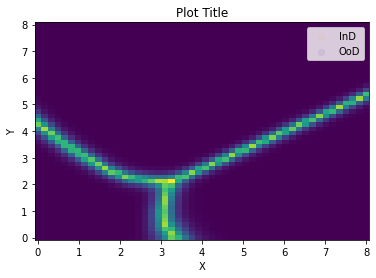

In [18]:
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
x, y = np.concatenate((IND_X[:,0],OOD_X[:,0])), np.concatenate((IND_X[:,1],OOD_X[:,1]))
nbins=50
# xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = torch.softmax(D(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)

# zi = torch.softmax(D(torch.tensor(np.vstack([xi.flatten(), yi.flatten()]).T, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)), shading='auto', alpha=1)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

### WOOD Training

In [38]:
from simulation import *
D_WOOD = DSIM()
# OOD data preparation
n_ood = 64
ood_bsz = 64
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 64
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=2)

OOD Batch Shape: torch.Size([64, 2])


  2%|▏         | 1/64 [00:07<07:39,  7.29s/it]

Epoch  # 1 | Tri loss: 0.9654                     | Tri accuracy: 0.6093
Epoch  # 1 | Val loss: 0.9461                     | Val accuracy: 0.6405


  5%|▍         | 3/64 [00:21<07:22,  7.26s/it]

Epoch  # 3 | Tri loss: 0.7939                     | Tri accuracy: 0.6463
Epoch  # 3 | Val loss: 0.7953                     | Val accuracy: 0.7636


  8%|▊         | 5/64 [00:35<07:02,  7.16s/it]

Epoch  # 5 | Tri loss: 0.7004                     | Tri accuracy: 0.7278
Epoch  # 5 | Val loss: 0.7099                     | Val accuracy: 0.9144


 11%|█         | 7/64 [00:50<06:47,  7.14s/it]

Epoch  # 7 | Tri loss: 0.6282                     | Tri accuracy: 0.6652
Epoch  # 7 | Val loss: 0.6458                     | Val accuracy: 0.6677


 14%|█▍        | 9/64 [01:04<06:29,  7.08s/it]

Epoch  # 9 | Tri loss: 0.5736                     | Tri accuracy: 0.6848
Epoch  # 9 | Val loss: 0.589                     | Val accuracy: 0.667


 17%|█▋        | 11/64 [01:18<06:16,  7.10s/it]

Epoch  # 11 | Tri loss: 0.4982                     | Tri accuracy: 0.6663
Epoch  # 11 | Val loss: 0.51                     | Val accuracy: 0.6694


 20%|██        | 13/64 [01:32<06:00,  7.07s/it]

Epoch  # 13 | Tri loss: 0.4432                     | Tri accuracy: 0.6934
Epoch  # 13 | Val loss: 0.4608                     | Val accuracy: 0.8789


 23%|██▎       | 15/64 [01:46<05:45,  7.06s/it]

Epoch  # 15 | Tri loss: 0.3923                     | Tri accuracy: 0.9071
Epoch  # 15 | Val loss: 0.4202                     | Val accuracy: 0.966


 27%|██▋       | 17/64 [02:00<05:28,  6.98s/it]

Epoch  # 17 | Tri loss: 0.3613                     | Tri accuracy: 0.953
Epoch  # 17 | Val loss: 0.3892                     | Val accuracy: 0.9845


 30%|██▉       | 19/64 [02:14<05:13,  6.98s/it]

Epoch  # 19 | Tri loss: 0.3444                     | Tri accuracy: 0.9809
Epoch  # 19 | Val loss: 0.3838                     | Val accuracy: 0.982


 33%|███▎      | 21/64 [02:28<05:00,  6.99s/it]

Epoch  # 21 | Tri loss: 0.3369                     | Tri accuracy: 0.975
Epoch  # 21 | Val loss: 0.3705                     | Val accuracy: 0.9889


 36%|███▌      | 23/64 [02:42<04:44,  6.93s/it]

Epoch  # 23 | Tri loss: 0.3297                     | Tri accuracy: 0.9854
Epoch  # 23 | Val loss: 0.3638                     | Val accuracy: 0.9902


 39%|███▉      | 25/64 [02:56<04:29,  6.92s/it]

Epoch  # 25 | Tri loss: 0.3236                     | Tri accuracy: 0.9859
Epoch  # 25 | Val loss: 0.3566                     | Val accuracy: 0.9928


 42%|████▏     | 27/64 [03:09<04:15,  6.91s/it]

Epoch  # 27 | Tri loss: 0.3156                     | Tri accuracy: 0.9824
Epoch  # 27 | Val loss: 0.3572                     | Val accuracy: 0.9889


 45%|████▌     | 29/64 [03:23<04:00,  6.88s/it]

Epoch  # 29 | Tri loss: 0.3093                     | Tri accuracy: 0.9945
Epoch  # 29 | Val loss: 0.3479                     | Val accuracy: 0.9954


 48%|████▊     | 31/64 [03:37<03:46,  6.86s/it]

Epoch  # 31 | Tri loss: 0.2995                     | Tri accuracy: 0.9857
Epoch  # 31 | Val loss: 0.3378                     | Val accuracy: 0.9727


 52%|█████▏    | 33/64 [03:51<03:32,  6.85s/it]

Epoch  # 33 | Tri loss: 0.2932                     | Tri accuracy: 0.9987
Epoch  # 33 | Val loss: 0.3331                     | Val accuracy: 0.9997


 55%|█████▍    | 35/64 [04:05<03:22,  6.98s/it]

Epoch  # 35 | Tri loss: 0.2873                     | Tri accuracy: 0.9993
Epoch  # 35 | Val loss: 0.3205                     | Val accuracy: 0.9997


 58%|█████▊    | 37/64 [04:18<03:05,  6.88s/it]

Epoch  # 37 | Tri loss: 0.279                     | Tri accuracy: 0.9993
Epoch  # 37 | Val loss: 0.3205                     | Val accuracy: 0.9997


 61%|██████    | 39/64 [04:32<02:51,  6.85s/it]

Epoch  # 39 | Tri loss: 0.269                     | Tri accuracy: 0.9997
Epoch  # 39 | Val loss: 0.302                     | Val accuracy: 0.9997


 64%|██████▍   | 41/64 [04:46<02:37,  6.84s/it]

Epoch  # 41 | Tri loss: 0.2563                     | Tri accuracy: 0.9997
Epoch  # 41 | Val loss: 0.2904                     | Val accuracy: 0.9997


 67%|██████▋   | 43/64 [04:59<02:22,  6.80s/it]

Epoch  # 43 | Tri loss: 0.2476                     | Tri accuracy: 1.0
Epoch  # 43 | Val loss: 0.2787                     | Val accuracy: 0.9997


 70%|███████   | 45/64 [05:13<02:08,  6.76s/it]

Epoch  # 45 | Tri loss: 0.2406                     | Tri accuracy: 1.0
Epoch  # 45 | Val loss: 0.273                     | Val accuracy: 0.9997


 73%|███████▎  | 47/64 [05:26<01:54,  6.76s/it]

Epoch  # 47 | Tri loss: 0.2211                     | Tri accuracy: 1.0
Epoch  # 47 | Val loss: 0.2598                     | Val accuracy: 1.0


 77%|███████▋  | 49/64 [05:40<01:41,  6.79s/it]

Epoch  # 49 | Tri loss: 0.2096                     | Tri accuracy: 1.0
Epoch  # 49 | Val loss: 0.2449                     | Val accuracy: 1.0


 80%|███████▉  | 51/64 [05:53<01:28,  6.81s/it]

Epoch  # 51 | Tri loss: 0.1951                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.228                     | Val accuracy: 1.0


 83%|████████▎ | 53/64 [06:07<01:15,  6.83s/it]

Epoch  # 53 | Tri loss: 0.1777                     | Tri accuracy: 1.0
Epoch  # 53 | Val loss: 0.2101                     | Val accuracy: 1.0


 86%|████████▌ | 55/64 [06:21<01:01,  6.85s/it]

Epoch  # 55 | Tri loss: 0.1641                     | Tri accuracy: 1.0
Epoch  # 55 | Val loss: 0.1994                     | Val accuracy: 1.0


 89%|████████▉ | 57/64 [06:35<00:48,  6.88s/it]

Epoch  # 57 | Tri loss: 0.1506                     | Tri accuracy: 1.0
Epoch  # 57 | Val loss: 0.1864                     | Val accuracy: 1.0


 92%|█████████▏| 59/64 [06:48<00:34,  6.88s/it]

Epoch  # 59 | Tri loss: 0.1323                     | Tri accuracy: 1.0
Epoch  # 59 | Val loss: 0.1727                     | Val accuracy: 1.0


 95%|█████████▌| 61/64 [07:02<00:20,  6.90s/it]

Epoch  # 61 | Tri loss: 0.1181                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.1485                     | Val accuracy: 1.0


 98%|█████████▊| 63/64 [07:16<00:06,  6.91s/it]

Epoch  # 63 | Tri loss: 0.1047                     | Tri accuracy: 1.0
Epoch  # 63 | Val loss: 0.1471                     | Val accuracy: 1.0


100%|██████████| 64/64 [07:23<00:00,  6.93s/it]


torch.Size([2500, 3])


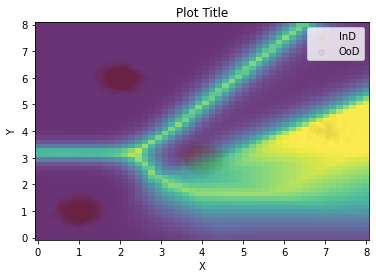

In [39]:
from wasserstein import *
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=0.05)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=0.05)
xi = np.linspace(0, 8, 50, endpoint=True)
yi = np.linspace(0, 8, 50, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [30]:
xy_pos.reshape((50, 50, 2))

array([[[0.        , 0.        ],
        [0.        , 0.16326531],
        [0.        , 0.32653061],
        ...,
        [0.        , 7.67346939],
        [0.        , 7.83673469],
        [0.        , 8.        ]],

       [[0.16326531, 0.        ],
        [0.16326531, 0.16326531],
        [0.16326531, 0.32653061],
        ...,
        [0.16326531, 7.67346939],
        [0.16326531, 7.83673469],
        [0.16326531, 8.        ]],

       [[0.32653061, 0.        ],
        [0.32653061, 0.16326531],
        [0.32653061, 0.32653061],
        ...,
        [0.32653061, 7.67346939],
        [0.32653061, 7.83673469],
        [0.32653061, 8.        ]],

       ...,

       [[7.67346939, 0.        ],
        [7.67346939, 0.16326531],
        [7.67346939, 0.32653061],
        ...,
        [7.67346939, 7.67346939],
        [7.67346939, 7.83673469],
        [7.67346939, 8.        ]],

       [[7.83673469, 0.        ],
        [7.83673469, 0.16326531],
        [7.83673469, 0.32653061],
        .

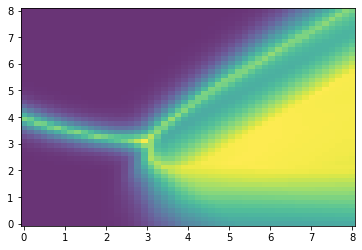

In [26]:
plt.pcolormesh(xi, yi, si.reshape((50,50)).T, shading='auto', alpha=0.8)

### OOD GAN Training

In [ ]:
from simulation import *
D_GAN = DSIM()
G_GAN = GSIM()
# OOD data preparation
n_ood = 64
ood_bsz = 64
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 64
lr = 1e-3
beta = 0.1
n_dim = 1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_GAN, G_GAN = oodgan_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch)